# H-matrix compression example with Volume and Surface Integral Equations

In this notebook we will test the compression of the adjoint double layer VSIE operator (interior points) for the Helmholtz equation on a skull slab mesh.

In [1]:
# autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from time import time
import MyHM.structures as stt
from MyHM.numba.VSIE import build_system_VSIE, Info_VSIE
from MyHM.numba.VSIE import single_layer_partial_nb, cross_single_layer_partial_nb, double_layer_partial_nb, cross_double_layer_partial_nb, ad_double_layer_partial_nb, cross_ad_double_layer_partial_nb
from MyHM.numba import ACAPP_numba, ACAPP_CCC_numba, ACAPlusPP_numba, ACAPlusPP_CCC_numba

# Plots:
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

First, we load the voxelized data to be used:

In [3]:
points = np.load("Voxels data/voxel_points_moved.npy")
densities = np.load("Voxels data/density_of_sound.npy")
speeds = np.load("Voxels data/speed_of_sound.npy")
print(points.shape)

(3, 201378)


In [4]:
np.min(points, axis=1), np.max(points, axis=1)

(array([-0.03122591, -0.04866769, -0.02514643]),
 array([ 0.0303278 , -0.02277605,  0.02385357]))

The amount of data is too large (~648GB for its matrix with complex numbers of 128 bits) for a personal computer, so we will generate cuts in the skull slab to reduce the dimensions: 

In [5]:
mask = points[0,:] > -0.009
mask *= points[0,:] < 0.009
mask *= points[2,:] > -0.009
mask *= points[2,:] < 0.009

points = points[:, mask]
densities = densities[mask]
speeds = speeds[mask]
print(points.shape)

(3, 25249)


We can plot the new points:

In [ ]:
# Plot points  
all_vertices = points

fig = go.Figure(data=[
    go.Scatter3d(x=all_vertices[0,:], y=all_vertices[1,:], z=all_vertices[2,:],
                    mode='markers', marker=dict(size=1)
    ),
    ])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    showlegend=False
)
fig.show()

The new points will generate a system of about 10GB of memory.

The second step is to build the system associated with the voxels. The following function will take care of calculating everything we need (e.g. bone surface, normals, weights, density gradients, etc):

In [7]:
%time info, vox_size = build_system_VSIE(points, densities, speeds)

Points shape: (3, 25249)
Vox size: [0.00048852 0.00048852 0.0005    ]
Bounding box:
[[-0.00899818  0.00907712]
 [-0.03572187 -0.02302031]
 [-0.00889643  0.00910357]]
(nx, ny, nz): 37.00000000000185 26.00000000000125 36.00000000000189
Voxels in each dimension: 37 * 26 * 36 = 34632
Check if all values are in 3D array: (25249,) (25249,)
Check if all points are considered in the masks.: (25249,) 25249

CPU times: total: 1.12 s
Wall time: 2.98 s


Then, we must create the necessary trees for compression. As we want to compress the adjoint double layer, we have to work with the grid points of the interior:

In [8]:
# Vertices:
vertices = info.int_grid
print("Shape vertices:", vertices.shape)

# Bbox:
mins = np.min(vertices, axis=0)
maxs = np.max(vertices, axis=0)
bbox_space = np.array([mins - (vox_size/2), maxs + (vox_size/2)]).T
print("Bbox space:", bbox_space)

# DOF indices:
dof_indices = list(range(vertices.shape[0]))
print("DOF indices:", len(dof_indices))

# Octree:
maximum_element_diameter = np.sqrt(np.sum(vox_size**2))
octree = stt.Octree(vertices, dof_indices, bbox_space, maximum_element_diameter, max_depth=4) # The max_depth value can be changed to achieve better compressions
%time octree.generate_tree()

# Admissibility tree:
tree_3d = stt.Tree3D(octree, octree, dtype=np.complex128)
%time tree_3d.generate_adm_tree()


Shape vertices: (25249, 3)
Bbox space: [[-0.00899818  0.00907712]
 [-0.03572187 -0.02302031]
 [-0.00889643  0.00910357]]
DOF indices: 25249
CPU times: total: 156 ms
Wall time: 223 ms
CPU times: total: 1min 16s
Wall time: 1min 44s


In [9]:
# Stats of the admissibility tree:
tree_3d.stats

{'number_of_nodes': 2077685,
 'number_of_leaves': 2040313,
 'number_of_not_adm_leaves': 331001,
 'number_of_adm_leaves': 1709312}

Before compressing, let's calculate the entire matrix to obtain the complete result and compare it later:

In [10]:
numba_assembler = ad_double_layer_partial_nb

# We want all rows and columns of the matrix:
rows = np.arange(vertices.shape[0])
cols = np.arange(vertices.shape[0])
A = numba_assembler(rows, cols, info, dtype=np.complex128)

# Get random vector and calculate matvec:
b = np.random.rand(A.shape[0])
result = A@b

# Delete full matrix:
del A

Finally, let us compress the matrix for different values of epsilon and compare the results of the matvecs. This time we will use accelerated functions with Numba and a partial matrix assembler, that is, the compression algorithm will calculate the rows and columns of the matrix as it needs them. Additionally, we have implemented four different versions of the Adaptive Cross Approximation (ACA) algorithm. In this opportunity we will use the classical version (ACAPP_numba), however, for other VSIE operators, it may be necessary to use one of the others to obtain good compressions.

In [11]:
epsilons = [2**(-1*i) for i in range(1,50,4)][:5]
formatted_epsilons = [np.format_float_scientific(e, precision=3) for e in epsilons]
errors = []
used_storages = []
total_storage_without_compression = tree_3d.calculate_matrix_storage_without_compression()
for i in range(len(epsilons)):
    print(f"\n{i:02}) Epsilon: {formatted_epsilons[i]}")

    t0 = time()
    tree_3d.add_compressed_matrix_numba(info, Info_VSIE, numba_assembler, ACAPP_numba, epsilons[i]) # Other compressors: ACAPP_CCC_numba, ACAPlusPP_numba, ACAPlusPP_CCC_numba
    tf = time()
    print(f"Time of compression (numba assembly ACAPP): {tf-t0} s")
    aux_result = tree_3d.dot(b)
    errors.append(np.linalg.norm(result - aux_result) / np.linalg.norm(result))
    used_storages.append(tree_3d.calculate_compressed_matrix_storage())
    tree_3d.clear_compression()


00) Epsilon: 5.e-01
Compilation time: 10.182924032211304 s
Time of compression (numba assembly ACAPP): 95.4945375919342 s

01) Epsilon: 3.125e-02
Compilation time: 0.09194374084472656 s
Time of compression (numba assembly ACAPP): 168.399240732193 s

02) Epsilon: 1.953e-03
Compilation time: 0.049846649169921875 s
Time of compression (numba assembly ACAPP): 157.14982914924622 s

03) Epsilon: 1.221e-04
Compilation time: 0.05597734451293945 s
Time of compression (numba assembly ACAPP): 158.54500198364258 s

04) Epsilon: 7.629e-06
Compilation time: 0.3647885322570801 s
Time of compression (numba assembly ACAPP): 207.88654804229736 s


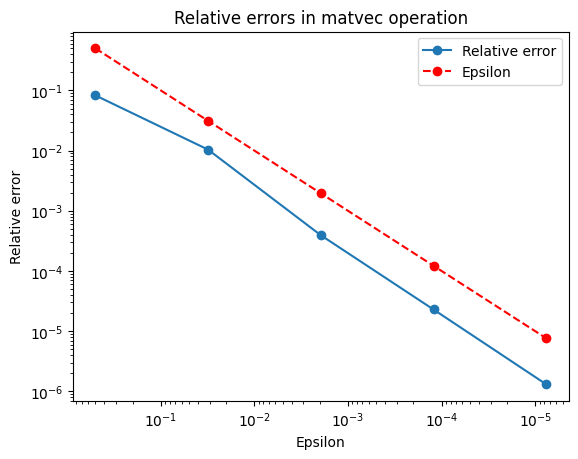

In [12]:
# Relative errors plot:
plt.plot(epsilons, errors, "o-", label="Relative error")
plt.plot(epsilons, epsilons, "or--", label="Epsilon")
plt.gca().invert_xaxis()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Relative error")
plt.title("Relative errors in matvec operation")
plt.legend()
plt.show()

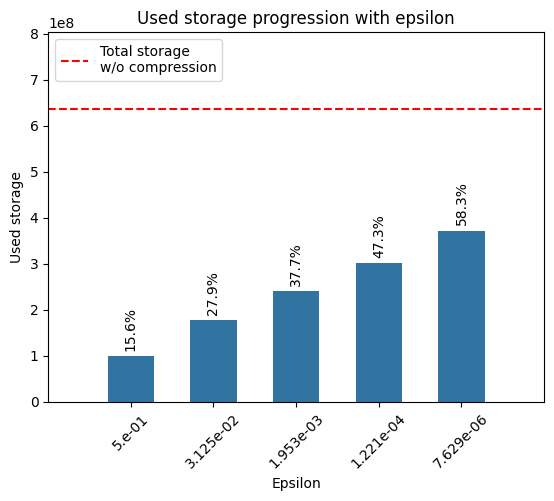

In [13]:
# Storage progession plot:
df = pd.DataFrame({"Used storage": used_storages, "Epsilon": formatted_epsilons})
ax = sns.barplot(df, x="Epsilon", y="Used storage", errorbar=None, gap=0.3)
bar_labels = np.round(np.asarray(used_storages) / total_storage_without_compression * 100, decimals=1)
ax.bar_label(ax.containers[0], fontsize=10, rotation=90, padding=4, labels=map(lambda x: f"{x}%", bar_labels))
xlim = plt.xlim()
xlim = (xlim[0] - 0.5, xlim[1] + 0.5)
plt.xlim(xlim)
plt.axhline(y=total_storage_without_compression, label="Total storage\nw/o compression", linestyle="--", color='r')
ylim = plt.ylim()
ylim = (ylim[0], ylim[1] * 1.2)
plt.ylim(ylim)
plt.title("Used storage progression with epsilon")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()